In [1]:
import tensorflow as tf
import keras_cv
import keras
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib.pyplot as plt
import numpy as np
print("tf.__version__:", tf.__version__)
print("keras.__version__:", keras.__version__)
print("keras_cv.__version__:", keras_cv.__version__)
from datetime import datetime
import gc
import time
from datetime import datetime

2025-04-02 10:24:09.569026: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 10:24:09.576629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743582249.584617  234786 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743582249.587090  234786 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743582249.594176  234786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

tf.__version__: 2.19.0
keras.__version__: 3.9.1
keras_cv.__version__: 0.9.0


In [2]:
import keras_cv
print(keras_cv.models.RetinaNet.presets.keys())
print(keras_cv.models.YOLOV8Detector.presets.keys())
print(keras_cv.models.EfficientNetLiteBackbone.presets.keys())

dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resnet50_v

In [3]:
# backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco")
# yolo = keras_cv.models.YOLOV8Detector(
#     num_classes=20,
#     bounding_box_format="xyxy",
#     backbone=backbone,
#     fpn_depth=1,
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,global_clipnorm=10,)
# yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")


In [4]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
import os
import json
import csv
import xml.etree.ElementTree as ET
from tqdm import tqdm
import keras_cv
import keras
import math
from collections import defaultdict
from PIL import Image
import matplotlib.patches as patches
from pprint import pprint
import matplotlib.pyplot as plt 


def build_image_detection_pipeline(img_path=None, labels_path=None, annotation_format="yolo", 
                                  img_size=None, batch_size=32, augment_strength={'rotation':0.1,
                                                                                       'shear':0.1,
                                                                                       'hue':0.1,
                                                                                       'saturation':0.1,
                                                                                       'contrast':0.1,
                                                                                       'brightness':0.1,
                                                                                       'blur':0.1,
                                                                                       'cutout':0.1}):
    """
    Build an object detection pipeline supporting multiple annotation formats
    
    Parameters:
    - img_path: Path to images
    - labels_path: Path to annotations. For 'coco' and 'edge_impulse_json', this is the path to the single JSON file.
    - annotation_format: One of "yolo", "pascal_voc", "coco", "csv", "edge_impulse_json"
    - img_size: Image dimensions (height, width)
    - batch_size: Batch size for training
    
    Returns:
    - train_ds: Training dataset
    - val_ds: Validation dataset
    - class_mapping: Dictionary mapping class IDs to class names
    """
    if img_size == None:
        #infer size from first image
        img = Image.open(os.path.join(img_path,os.listdir(img_path)[0]))
        img_size = img.size
    
    if isinstance(augment_strength, float):
        #set float values to all augmentations
        strength = augment_strength
        augment_strength= {'rotation':strength,
                           'shear':strength,
                           'hue':strength,
                           'saturation':strength,
                           'contrast':strength,
                           'brightness':strength,
                           'blur':strength,
                           'cutout':strength}
        
    # YOLO format parser (original)
    def parse_yolo_labels(label_path):
        label = open(label_path, 'r').read().split('\n')
        
        class_ids = []
        bbs = []
        for line in label:
            if line == '':
                continue
            #first string before space is the class, after that is the bounding box
            class_id = int(line.split(' ')[0])
            # Check if class_id is a number or string
            #read bounding box
            bb = line.split(' ')[1:]
            bb = [float(i) for i in bb]
            #clip values to 0 and 1
            bb = [max(0,i) for i in bb]
            bb = [min(1,i) for i in bb]
            
            # YOLO format is x_center, y_center, width, height
            # Convert to x1, y1, x2, y2 format
            x_center, y_center, width, height = bb
            x1 = (x_center - width/2) * img_size[0]
            y1 = (y_center - height/2) * img_size[1]
            x2 = (x_center + width/2) * img_size[0]
            y2 = (y_center + height/2) * img_size[1]
            
            class_ids.append(class_id)
            bbs.append([x1, y1, x2, y2])
            
        return class_ids, bbs
    
    # Pascal VOC format parser
    def parse_pascal_voc_labels(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        class_ids = []
        bbs = []
        
        for obj in root.findall('object'):
            class_id = obj.find('name').text
            bbox = obj.find('bndbox')
            x1 = float(bbox.find('xmin').text)
            y1 = float(bbox.find('ymin').text)
            x2 = float(bbox.find('xmax').text)
            y2 = float(bbox.find('ymax').text)
            
            class_ids.append(class_id)
            bbs.append([x1, y1, x2, y2])
            
        return class_ids, bbs
    
    # COCO format parser
    def parse_coco_labels(img_file, coco_json_path):
        # Extract image filename
        img_filename = os.path.basename(img_file)
        
        # Load COCO JSON
        with open(coco_json_path, 'r') as f:
            coco_data = json.load(f)
        
        # Find image ID
        img_id = None
        for img in coco_data['images']:
            if img['file_name'] == img_filename:
                img_id = img['id']
                img_width = img['width']
                img_height = img['height']
                break
        
        if img_id is None:
            return [], []
        
        class_ids = []
        bbs = []
        
        # Find annotations for this image
        for ann in coco_data['annotations']:
            if ann['image_id'] == img_id:
                # COCO uses category_id
                category_id = ann['category_id']
                
                # Map COCO category to our class list
                # We need to find the category name first
                category_name = None
                for cat in coco_data['categories']:
                    if cat['id'] == category_id:
                        category_name = cat['name']
                        break
                
                class_id = category_name
    
                # COCO format: [x, y, width, height]
                x, y, width, height = ann['bbox']
                
                # Convert to x1, y1, x2, y2
                x1 = x * img_size[0] / img_width
                y1 = y * img_size[1] / img_height
                x2 = (x + width) * img_size[0] / img_width
                y2 = (y + height) * img_size[1] / img_height
                
                class_ids.append(class_id)
                bbs.append([x1, y1, x2, y2])
        
        return class_ids, bbs
    
    # CSV format parser
    def parse_csv_labels(csv_file, img_file):
        img_filename = os.path.basename(img_file)
        
        class_ids = []
        bbs = []
        
        with open(csv_file, 'r') as f:
            csv_reader = csv.reader(f)
            # Skip header if exists
            header = next(csv_reader, None)
            
            for row in csv_reader:
                # CSV format can vary, but typically:
                # filename, class, xmin, ymin, xmax, ymax
                if len(row) >= 6 and row[0] == img_filename:
                    class_id = row[1]
                    
                    # Parse coordinates
                    xmin, ymin, xmax, ymax = map(float, row[2:6])
                    
                    # Scale to our image size
                    x1 = xmin * img_size[0]
                    y1 = ymin * img_size[1]
                    x2 = xmax * img_size[0]
                    y2 = ymax * img_size[1]
                    
                    class_ids.append(class_id)
                    bbs.append([x1, y1, x2, y2])
        
        return class_ids, bbs

    # Edge Impulse JSON format parser
    def parse_edge_impulse_labels(img_file, ei_data):
        img_filename = os.path.basename(img_file)
        class_ids = []
        bbs = []

        # Check if the image file exists as a key in the boundingBoxes dictionary
        if img_filename in ei_data.get('boundingBoxes', {}):
            annotations = ei_data['boundingBoxes'][img_filename]
            
            for ann in annotations:
                label = ann['label']
                x = ann['x']
                y = ann['y']
                width = ann['width']
                height = ann['height']
                
                # Convert to x1, y1, x2, y2 format
                x1 = float(x)
                y1 = float(y)
                x2 = float(x + width)
                y2 = float(y + height)
                
                class_ids.append(label)
                bbs.append([x1, y1, x2, y2])
        # else: # Handle case where image might not be in the json, though typically it should be
        #     print(f"Warning: Image file {img_filename} not found in Edge Impulse JSON labels.")
            
        return class_ids, bbs

    # Validate required paths
    if img_path is None or labels_path is None:
        raise ValueError("Both img_path and labels_path must be provided")
    
    # Get image files
    all_files_in_img_path = sorted(os.listdir(img_path))
    # Filter out potential non-image files if necessary, e.g., based on extension
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'} 
    files = [os.path.join(img_path, f) for f in all_files_in_img_path 
             if os.path.splitext(f)[1].lower() in image_extensions]
    
    if not files:
        raise FileNotFoundError(f"No valid image files found in {img_path}")

    # Infer img_size from the first valid image file if not provided
    if img_size is None:
        try:
            with Image.open(files[0]) as img:
                # Note: PIL returns (width, height), but KerasCV often uses (height, width)
                # Let's keep it as (width, height) from PIL for now, and assume downstream handles it.
                # Or explicitly swap: img_size = (img.height, img.width) if needed elsewhere.
                img_size = img.size 
            print(f"Inferred image size (width, height): {img_size}")
        except Exception as e:
            raise ValueError(f"Could not open the first image {files[0]} to infer size: {e}")
            
    class_ids_all = []
    bbs_all = []
    
    # Parse annotations based on format
    annotation_format_lower = annotation_format.lower()
    
    if annotation_format_lower == "yolo":
        label_files = []
        corresponding_files = []
        # Match image files with label files (assuming same base name, different extension)
        for img_file in files:
            base_name = os.path.splitext(os.path.basename(img_file))[0]
            potential_label_path = os.path.join(labels_path, base_name + ".txt")
            if os.path.exists(potential_label_path):
                label_files.append(potential_label_path)
                corresponding_files.append(img_file)
            # else:
            #     print(f"Warning: No corresponding YOLO label found for {img_file}")

        files = corresponding_files # Update files list to only include those with labels
        print(f"Processing {len(files)} images with corresponding YOLO labels.")
        for label_file in tqdm(label_files, desc="Parsing YOLO labels"):
            class_id, bb = parse_yolo_labels(label_file)
            class_ids_all.append(class_id)
            bbs_all.append(bb)
            
    elif annotation_format_lower == "pascal_voc":
        xml_files = []
        corresponding_files = []
        # Match image files with xml files
        for img_file in files:
            base_name = os.path.splitext(os.path.basename(img_file))[0]
            potential_xml_path = os.path.join(labels_path, base_name + ".xml")
            if os.path.exists(potential_xml_path):
                xml_files.append(potential_xml_path)
                corresponding_files.append(img_file)
            # else:
            #     print(f"Warning: No corresponding Pascal VOC label found for {img_file}")
                
        files = corresponding_files # Update files list
        print(f"Processing {len(files)} images with corresponding Pascal VOC labels.")
        for xml_file in tqdm(xml_files, desc="Parsing Pascal VOC labels"):
            class_id, bb = parse_pascal_voc_labels(xml_file)
            class_ids_all.append(class_id)
            bbs_all.append(bb)
            
    elif annotation_format_lower == "coco":
        # For COCO, labels_path should be the path to the single JSON file
        print(f"Loading COCO annotations from: {labels_path}")
        try:
            with open(labels_path, 'r') as f:
                coco_data = json.load(f)
        except Exception as e:
            raise ValueError(f"Error loading COCO JSON file {labels_path}: {e}")
            
        print(f"Processing {len(files)} images using COCO annotations.")
        for img_file in tqdm(files, desc="Parsing COCO labels"):
            class_id, bb = parse_coco_labels(img_file, coco_data) # Pass loaded data
            class_ids_all.append(class_id)
            bbs_all.append(bb)
            
    elif annotation_format_lower == "csv":
        # For CSV, labels_path should be the path to the single CSV file
        print(f"Processing {len(files)} images using CSV annotations from: {labels_path}")
        for img_file in tqdm(files, desc="Parsing CSV labels"):
            class_id, bb = parse_csv_labels(labels_path, img_file)
            class_ids_all.append(class_id)
            bbs_all.append(bb)
            
    elif annotation_format_lower == "edge_impulse_json":
        # For Edge Impulse JSON, labels_path is the path to the single JSON file
        print(f"Loading Edge Impulse annotations from: {labels_path}")
        try:
            with open(labels_path, 'r') as f:
                ei_data = json.load(f)
                # Basic validation of the loaded structure
                if "boundingBoxes" not in ei_data:
                     raise ValueError("Edge Impulse JSON missing 'boundingBoxes' key.")
        except Exception as e:
            raise ValueError(f"Error loading or parsing Edge Impulse JSON file {labels_path}: {e}")

        print(f"Processing {len(files)} images using Edge Impulse JSON annotations.")
        valid_files_ei = []
        for img_file in tqdm(files, desc="Parsing Edge Impulse labels"):
            # Check if the image filename exists in the JSON before parsing
            img_filename = os.path.basename(img_file)
            if img_filename in ei_data.get('boundingBoxes', {}):
                class_id, bb = parse_edge_impulse_labels(img_file, ei_data)
                class_ids_all.append(class_id)
                bbs_all.append(bb)
                valid_files_ei.append(img_file) # Keep track of files that had entries
            # else:
            #     print(f"Warning: Image file {img_filename} not found in Edge Impulse JSON labels. Skipping.")
        
        # Update the list of files to only include those found in the JSON
        files = valid_files_ei 
        if not files:
             raise ValueError("No image files from the directory were found in the Edge Impulse JSON labels file.")
        print(f"Found annotations for {len(files)} images in the Edge Impulse JSON.")

    else:
        raise ValueError(f"Unsupported annotation format: {annotation_format}. " +
                         "Supported formats: yolo, pascal_voc, coco, csv, edge_impulse_json")
    
    
    def parse_images(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image,channels=3) 
        #image = tf.image.resize(image, img_size)
        return image
    
    def load_dataset(img_file, id, bb):
        image = parse_images(img_file)
        #bb to normal tensor
        bounding_boxes = {"boxes": tf.cast(bb, dtype=tf.float32), "classes": tf.cast(id, dtype=tf.float32)}
        bounding_boxes = keras_cv.bounding_box.to_dense(bounding_boxes)
        return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
    
    #sort class_ids alphabetically
    #create class mapping from class_ids string -> int
    class_mapping = {}
    for class_id in class_ids_all:
        for id in class_id:
            if id not in class_mapping:
                class_mapping[id] = len(class_mapping)
    # for i in range(len(class_mapping.unique())):
    #     class_mapping[i] = class_ids[i]
    
        
        
    print('class_mapping:',class_mapping)
    class_ids = [[class_mapping[id] for id in ids] for ids in class_ids_all]
    class_ids = tf.ragged.constant(class_ids)
    bbs = tf.ragged.constant(bbs_all)
    print('bbs:',bbs[:5])
    print('class_ids:',class_ids[:5])
    files = tf.ragged.constant(files)
    dataset = tf.data.Dataset.from_tensor_slices((files, class_ids, bbs))
    dataset = dataset.shuffle(len(files))

    train_size = int(0.7 * len(files))
    val_size = int(0.3 * len(files))
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size)
    
    augmentor = keras_cv.layers.Augmenter(
        [   keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
            #keras_cv.layers.RandomRotation( fill_mode="constant", bounding_box_format="xyxy", factor=augment_strength['rotation']),
            keras_cv.layers.RandomShear(bounding_box_format="xyxy",x_factor=augment_strength['shear'],y_factor=augment_strength['shear']),
            keras_cv.layers.RandomHue(value_range=(0,255),factor=augment_strength['hue']),
            keras_cv.layers.RandomSaturation(factor=(max(0.5-augment_strength['saturation'],0.0),min(0.5+augment_strength['saturation'],1.0))),
            keras_cv.layers.RandomContrast(value_range=(0,255),factor=augment_strength['contrast']),
            keras_cv.layers.RandomBrightness(value_range=(0,255),factor=augment_strength['brightness']),
            keras_cv.layers.RandomGaussianBlur(kernel_size=3, factor=augment_strength['blur']),
            keras_cv.layers.RandomCutout(height_factor=augment_strength['cutout'],width_factor=augment_strength['cutout'],fill_mode="gaussian_noise"),
            keras_cv.layers.Resizing(height=img_size[0], width=img_size[1], pad_to_aspect_ratio=True, bounding_box_format="xyxy",),
            keras_cv.layers.JitteredResize(target_size=(img_size[0],img_size[1]), scale_factor=(0.7, 1.3), bounding_box_format="xyxy"),
            #keras_cv.layers.Rescaling(scale=1./255)
        ]
    )
    resizing = keras.Sequential(layers=[keras_cv.layers.Resizing(height=img_size[0], width=img_size[1], pad_to_aspect_ratio=True, bounding_box_format="xyxy"),
                                        keras_cv.layers.JitteredResize(target_size=(img_size[0],img_size[1]),scale_factor=(0.75, 1.3),bounding_box_format="xyxy"),
                                        #keras_cv.layers.Rescaling(scale=1./255)
                                        ]
                                )

    
    train_ds = train_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.ragged_batch(batch_size, drop_remainder=True)
    train_ds = train_ds.map(augmentor, num_parallel_calls=tf.data.AUTOTUNE)
    
    
    val_ds = val_ds.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.ragged_batch(batch_size, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    def visualize_dataset(inputs, rows, cols):
        #take number of batches to fit rows*cols images
        batches_to_take = rows*cols//batch_size
        inputs = next(iter(inputs.take(batches_to_take)))
        images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
        num_images_in_batch = tf.shape(images)[0]
        print(num_images_in_batch)
        print(images.shape)
        plot_cols = min(num_images_in_batch.numpy(), 5)
        plot_rows = num_images_in_batch.numpy() // plot_cols
        print(f"  Displaying images in a {plot_rows}x{plot_cols} grid.")
        id_to_label_mapping = {v: k for k, v in class_mapping.items()}
        id_to_str_id_mapping = {int_id: str(int_id) for int_id in class_mapping.values()}
        keras_cv.visualization.plot_bounding_box_gallery(
            images,
            value_range=(0,255),
            rows=plot_rows,
            cols=plot_cols,
            y_true=bounding_boxes,
            scale=5,
            font_scale=0.5,
            bounding_box_format='xyxy',
            class_mapping=id_to_str_id_mapping,
        )
        plt.show()
    
    #rows = max(min(batch_size // 4, 4),1)
    
    print("Training dataset:")
    visualize_dataset(train_ds, 4, 2)
    print("Validation dataset:")
    visualize_dataset(val_ds, 4, 2)
    
    plt.show()

    def dict_to_tuple(inputs):
        return inputs["images"], keras_cv.bounding_box.to_dense(
            inputs["bounding_boxes"], max_boxes=32
        )
    
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    #sort class_mapping by value
    class_mapping = dict(sorted(class_mapping.items(), key=lambda item: item[0]))
    for i in range(len(class_mapping)):
        #find key where value is i
        for key, value in class_mapping.items():
            if value == i:
                print(f"Class {i}: {key}")
        
    
    return train_ds, val_ds, class_mapping


Loading Edge Impulse annotations from: Trainingsbilder_norbert/all/bounding_boxes.labels
Processing 32 images using Edge Impulse JSON annotations.


Parsing Edge Impulse labels: 100%|██████████| 32/32 [00:00<00:00, 398272.19it/s]

Found annotations for 24 images in the Edge Impulse JSON.
class_mapping: {'Cup': 0, 'Face': 1}



I0000 00:00:1743582252.155052  234786 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


bbs: <tf.RaggedTensor [[[139.0, 130.0, 168.0, 160.0],
  [88.0, 71.0, 118.0, 106.0]]  , [[148.0, 129.0, 175.0, 165.0],
                                  [71.0, 57.0, 109.0, 103.0]]  ,
 [[97.0, 75.0, 126.0, 118.0],
  [134.0, 133.0, 162.0, 164.0]], [[93.0, 71.0, 124.0, 106.0]],
 [[80.0, 48.0, 123.0, 108.0]]]>
class_ids: <tf.RaggedTensor [[0, 1], [0, 1], [1, 0], [1], [1]]>
Training dataset:
tf.Tensor(8, shape=(), dtype=int32)
(8, 128, 128, 3)
  Displaying images in a 1x5 grid.


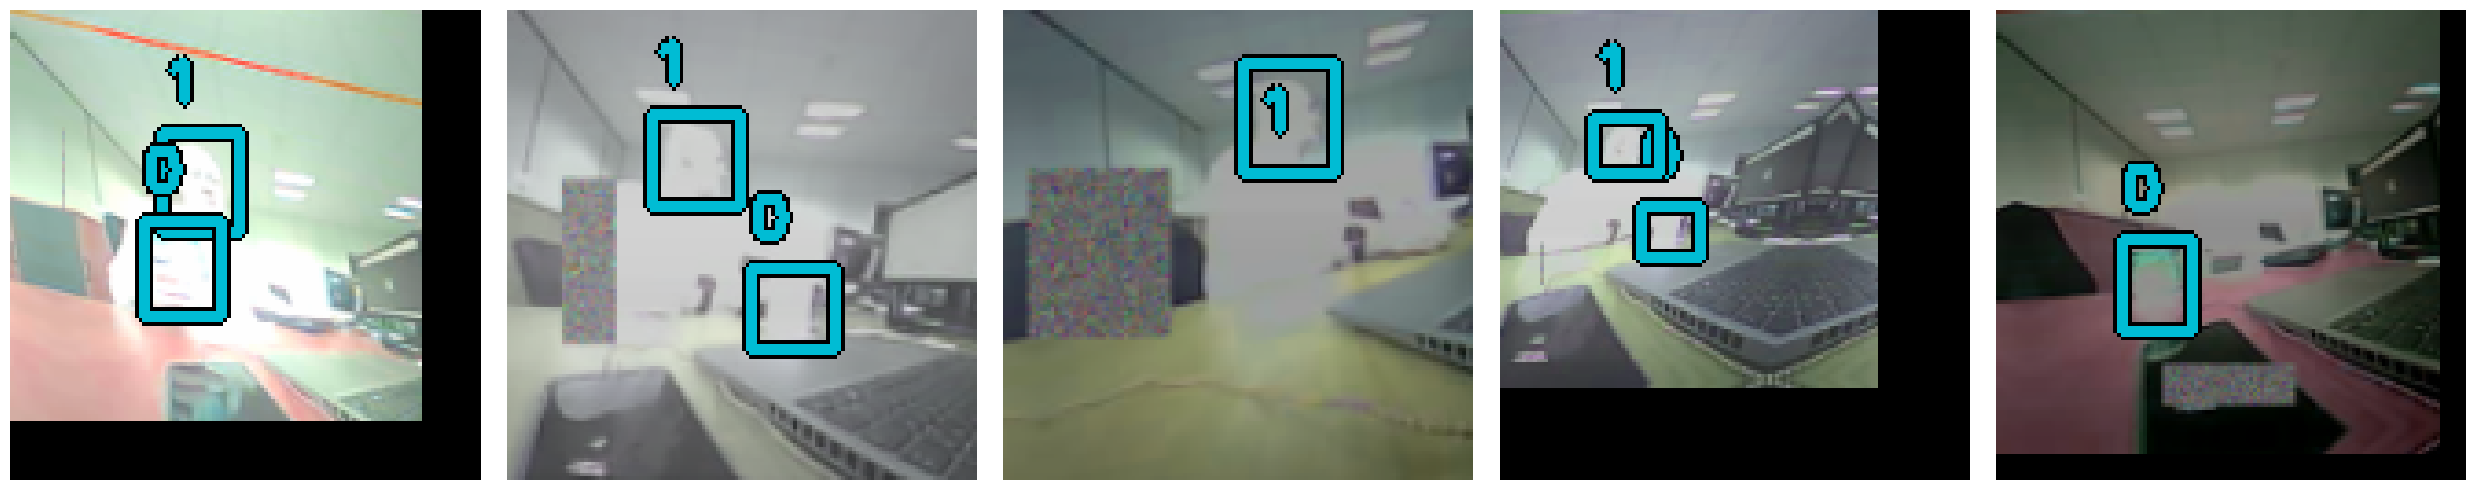

Validation dataset:
tf.Tensor(8, shape=(), dtype=int32)
(8, 128, 128, 3)
  Displaying images in a 1x5 grid.


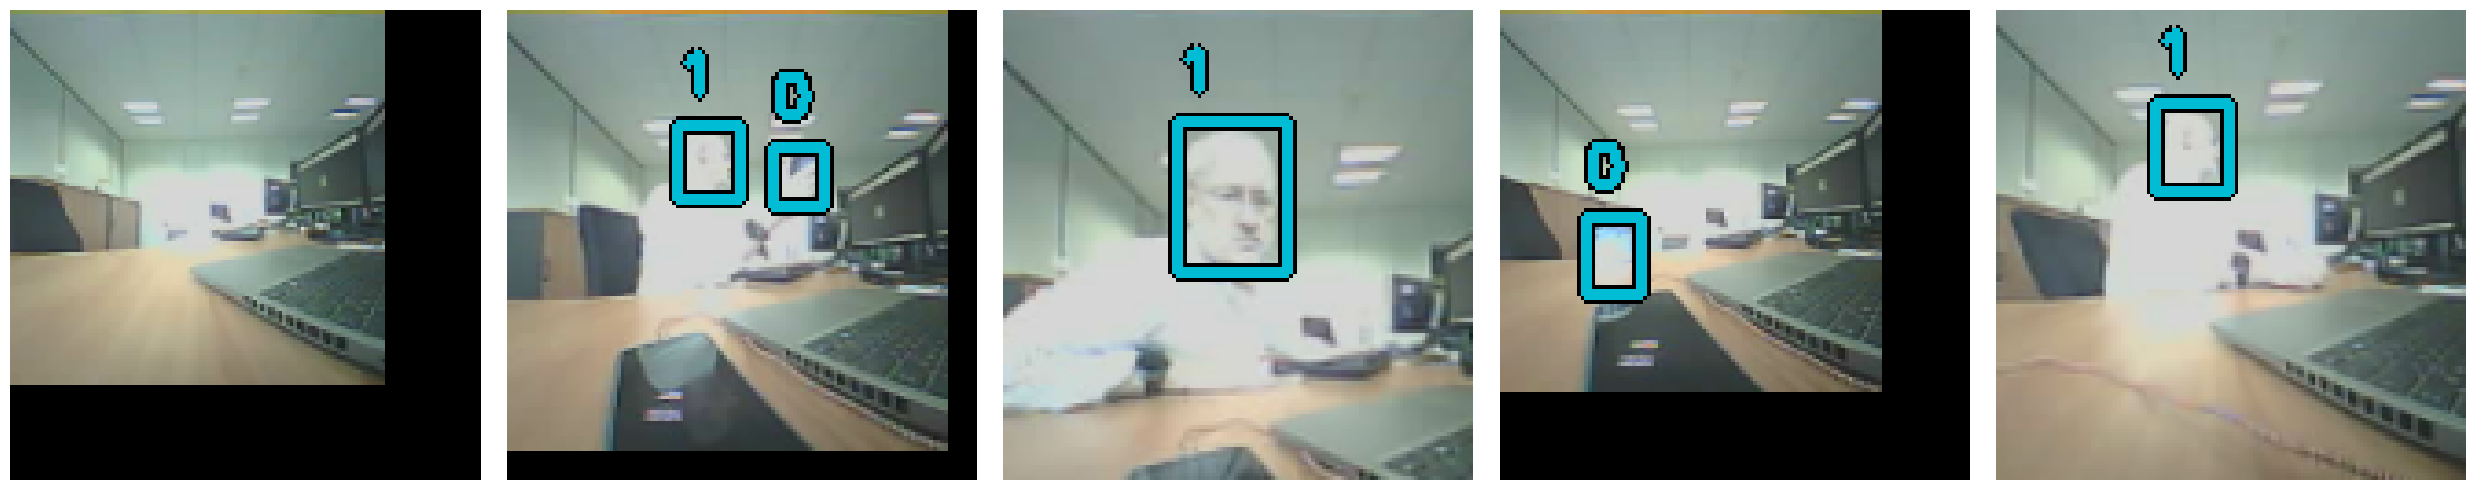

Class 0: Cup
Class 1: Face
num classes: 2


In [5]:
img_path = r'Trainingsbilder_norbert/all'
label_path= r'Trainingsbilder_norbert/all/bounding_boxes.labels'
#train_ds, val_ds, test_ds = build_img_dataset_pipeline(img_path, label_path, n_classes=20, img_size=(416, 416, 3), batch_size=16,img_type='jpeg', label_format='pascal_voc', return_filenames=False)
train_ds, val_ds, class_mapping = build_image_detection_pipeline(img_path=img_path, labels_path=label_path, annotation_format="edge_impulse_json",img_size=(128, 128), batch_size=8, augment_strength=0.3)
print('num classes:',len(class_mapping))


In [6]:

import keras_cv
import traceback # Make sure traceback is imported

# --- Revised get_backbone (Uses specific classes) ---
def get_backbone(backbone_type, weights, model_size):
    """
    Retrieves a KerasCV backbone instance by selecting the correct class and using its specific methods.
    Includes fallback logic.
    """
    assert backbone_type in ['resnetv2', 'cspdarknet', 'efficientnet', 'efficientnetlite', 'mobilenet', 'yolov8'], f"Backbone {backbone_type} not supported"
    assert weights in ['imagenet', 'coco', 'voc', None], f"Weights {weights} not supported"
    assert model_size in ['s', 'm', 'l', 'xl'], f"Model size {model_size} not supported"

    # --- Map generic size to specific model size names ---
    size_map = {
        'resnetv2':       {'s': '50', 'm': '50', 'l': '101', 'xl': '152'}, # Specific presets handle 18, 34 etc.
        'cspdarknet':     {'s': 'tiny', 'm': 's', 'l': 'm', 'xl': 'l'},
        'efficientnet':   {'s': 'b0', 'm': 'b1', 'l': 'b2', 'xl': 'b3'}, # Maps to EfficientNetV2
        'efficientnetlite':{'s': 'b0', 'm': 'b1', 'l': 'b2', 'xl': 'b3'},
        'mobilenet':      {'s': 'small', 'm': 'large', 'l': 'large', 'xl': 'large'}, # Maps to MobileNetV3
        'yolov8':         {'s': 'xs', 'm': 's', 'l': 'm', 'xl': 'l'},
    }

    # --- Map backbone_type string to the actual KerasCV Backbone Class ---
    backbone_cls_map = {
        # Use the base class; presets will determine the specific ResNetV2 size
        'resnetv2': keras_cv.models.ResNetV2Backbone,
        'cspdarknet': keras_cv.models.CSPDarkNetBackbone,
        'efficientnet': keras_cv.models.EfficientNetV2Backbone, # Defaulting to V2
        # EfficientNetLite needs size-specific classes for direct instantiation (if weights=None)
        'efficientnetlite': {
            'b0': keras_cv.models.EfficientNetLiteB0Backbone,
            'b1': keras_cv.models.EfficientNetLiteB1Backbone,
            'b2': keras_cv.models.EfficientNetLiteB2Backbone,
            'b3': keras_cv.models.EfficientNetLiteB3Backbone,
            'b4': keras_cv.models.EfficientNetLiteB4Backbone, # Add B4 if available and needed
        },
        'mobilenet': keras_cv.models.MobileNetV3Backbone, # Defaulting to V3
        'yolov8': keras_cv.models.YOLOV8Backbone,
    }

    specific_size = size_map.get(backbone_type, {}).get(model_size, None)
    if not specific_size:
        print(f"    Warning: Could not map size '{model_size}' for type '{backbone_type}'. Using default 'm' mapping.")
        specific_size = size_map.get(backbone_type, {}).get('m', None)

    if not specific_size:
        print(f"    ERROR: Could not determine specific size for {backbone_type}/{model_size}. Falling back.")
        try:
            # Use a known working preset as fallback if possible
            return keras_cv.models.ResNet50V2Backbone.from_preset("resnet50_v2")
        except Exception as fallback_e:
            print(f"    ERROR creating fallback ResNet50V2Backbone: {fallback_e}")
            return None

    # Get the specific backbone class (handle EfficientNetLite case)
    SpecificBackboneClass = None
    if backbone_type == 'efficientnetlite':
        # Get the specific class (e.g., EfficientNetLiteB0Backbone) from the nested dict
        SpecificBackboneClass = backbone_cls_map['efficientnetlite'].get(specific_size)
    elif backbone_type == 'resnetv2':
         # ResNetV2 uses the base class, presets define the size
         SpecificBackboneClass = backbone_cls_map['resnetv2']
    else:
        # Get the class directly for other types
        SpecificBackboneClass = backbone_cls_map.get(backbone_type)

    if SpecificBackboneClass is None:
        print(f"    ERROR: Could not find a specific KerasCV class for {backbone_type} (size {specific_size}). Falling back.")
        try:
            return keras_cv.models.ResNet50V2Backbone.from_preset("resnet50_v2")
        except Exception as fallback_e:
            print(f"    ERROR creating fallback ResNet50V2Backbone: {fallback_e}")
            return None

    backbone_instance = None

    # --- Direct Instantiation for weights=None ---
    if weights is None:
        print(f"    Instantiating {SpecificBackboneClass.__name__} directly (no weights).")
        try:
            # Add specific arguments if needed, e.g., include_rescaling
            # Important: Check the __init__ signature of the specific backbone class
            kwargs = {}
            if 'Lite' in SpecificBackboneClass.__name__: # Heuristic for EfficientNetLite
                 # EfficientNetLite backbones often expect include_rescaling
                 kwargs['include_rescaling'] = False # Set appropriately based on expected input

            # Handle ResNetV2 case where direct instantiation might need size info if not preset
            # However, for weights=None, a default ResNet might be okay, or we rely on preset below.
            # Sticking to direct instantiation for None weights for consistency.
            # If direct `ResNetV2Backbone()` fails, the fallback will catch it.
            backbone_instance = SpecificBackboneClass(**kwargs)
            print(f"    Successfully instantiated {SpecificBackboneClass.__name__} (weights=None).")
        except Exception as e_instantiate:
            print(f"    ERROR during direct instantiation of {SpecificBackboneClass.__name__}: {type(e_instantiate).__name__} - {str(e_instantiate)}")
            # Fall through to fallback logic at the end

    # --- Preset Loading for weights != None ---
    else:
        # Construct potential preset names
        base_preset = None
        weighted_preset = None
        preset_to_try = None

        # Use specific_size to construct the preset names
        if backbone_type == 'resnetv2':
             # Map generic size to specific ResNetV2 preset sizes
             resnet_preset_size_map = {'50': '50', '101': '101', '152': '152'} # Add 18, 34 if needed
             preset_specific_size = resnet_preset_size_map.get(specific_size, '50') # Default to 50
             base_preset = f"resnet{preset_specific_size}_v2"
        elif backbone_type == 'cspdarknet': base_preset = f"csp_darknet_{specific_size}"
        elif backbone_type == 'efficientnet': base_preset = f"efficientnetv2_{specific_size}"
        elif backbone_type == 'efficientnetlite':
             # Use the preset name you found works:
             base_preset = f"efficientnetlite_{specific_size}"
             # Note: There might not be standard *weighted* presets for EfficientNetLite backbones
        elif backbone_type == 'mobilenet': base_preset = f"mobilenet_v3_{specific_size}"
        elif backbone_type == 'yolov8': base_preset = f"yolo_v8_{specific_size}_backbone"

        if base_preset:
            # Construct weighted name if applicable
            if weights == 'imagenet' and backbone_type != 'efficientnetlite': # EffLite might not have imagenet presets
                weighted_preset = f"{base_preset}_imagenet"
            elif weights == 'coco' and backbone_type == 'yolov8':
                weighted_preset = f"{base_preset}_coco"
            # Add elif for 'voc' if specific backbone classes support voc presets, e.g.,
            # elif weights == 'voc' and backbone_type == 'yolov8' and specific_size == 'm':
            #    weighted_preset = 'yolo_v8_m_pascalvoc' # Detector preset, not backbone

            # Decide which name to try loading (prioritize weighted if exists)
            preset_to_try = weighted_preset if weighted_preset else base_preset
            # Define a potential fallback preset (e.g., the base if weighted failed)
            fallback_preset = base_preset if weighted_preset and base_preset != weighted_preset else None

            # Attempt loading the primary preset
            if preset_to_try:
                print(f"    Attempting to load preset on {SpecificBackboneClass.__name__}: '{preset_to_try}'")
                try:
                    # Use from_preset on the SPECIFIC class
                    backbone_instance = SpecificBackboneClass.from_preset(preset_to_try)
                    print(f"    Successfully loaded preset: '{preset_to_try}'")
                except Exception as e_preset1:
                    print(f"    Info: Failed loading preset '{preset_to_try}' on {SpecificBackboneClass.__name__}: {type(e_preset1).__name__} - {str(e_preset1)}")
                    # Attempt fallback preset if defined and different
                    if fallback_preset and fallback_preset != preset_to_try:
                         print(f"    Attempting to load fallback preset on {SpecificBackboneClass.__name__}: '{fallback_preset}'")
                         try:
                             backbone_instance = SpecificBackboneClass.from_preset(fallback_preset)
                             print(f"    Successfully loaded fallback preset: '{fallback_preset}'")
                         except Exception as e_preset2:
                             print(f"    Info: Failed loading fallback preset '{fallback_preset}' on {SpecificBackboneClass.__name__}: {type(e_preset2).__name__} - {str(e_preset2)}")
                             backbone_instance = None # Fallback failed
                    else:
                         backbone_instance = None # No fallback defined or primary failed

        else:
            print(f"    Warning: Could not construct a standard preset name for {backbone_type}/{weights}/{specific_size}. No preset loading attempted.")

    # --- Fallback if everything else failed ---
    if backbone_instance is None:
        print(f"    ERROR: Could not get backbone for {backbone_type}/{weights}/{model_size} via specific class methods. Falling back to default ResNet50V2Backbone (no weights).")
        try:
            # Attempt direct instantiation as the final fallback
            backbone_instance = keras_cv.models.ResNet50V2Backbone()
        except Exception as fallback_e:
            print(f"    ERROR creating final fallback ResNet50V2Backbone: {fallback_e}")
            backbone_instance = None # Complete failure

    return backbone_instance



# --- Corrected build_detection_model ---
def build_detection_model(n_classes, lr=0.001, model_name='ssd', weights='coco', model_size='s', backbone='standard'):
    """
    Builds a KerasCV object detection model with automatic fallback for problematic configurations.
    Returns both the model and the actual configuration used.
    """
    assert model_name in ['retinanet', 'yolov8'], f"Model {model_name} not supported in this version"
    assert weights in ['coco', 'imagenet', 'voc', None], f"Weights {weights} not supported"
    assert model_size in ['s', 'm', 'l', 'xl'], f"Model size {model_size} not supported"

    # Track actual configuration used (for logging/analysis)
    actual_config = {
        'model_name': model_name,
        'weights': weights,
        'model_size': model_size,
        'backbone': backbone
    }

    model = None
    print(f"  Building {model_name} (Size: {model_size}, Weights: {weights}, Backbone: {backbone})")

    try:
        # --- Handle COCO weights with fallback strategy ---
        if weights == 'coco' and backbone == 'standard':
            if model_name == 'retinanet':
                # RetinaNet COCO preset is broken, try ImageNet instead
                print("    Info: RetinaNet COCO preset unavailable. Trying ImageNet weights instead.")
                weights = 'imagenet'
                actual_config['weights'] = 'imagenet'
                actual_config['fallback_reason'] = 'COCO preset unavailable for RetinaNet'
            # YOLOv8 can proceed with COCO as it uses backbone presets

        # --- Use KerasCV Detector Presets if applicable ---
        detector_preset_name = None
        if backbone == 'standard':
            if model_name == 'retinanet' and weights == 'voc':
                detector_preset_name = 'retinanet_resnet50_pascalvoc'
            elif model_name == 'yolov8' and weights == 'voc':
                if model_size == 'm':
                    detector_preset_name = 'yolo_v8_m_pascalvoc'
                else:
                    print(f"    Info: YOLOv8 VOC preset only available for size 'm'. Using ImageNet weights instead.")
                    weights = 'imagenet'
                    actual_config['weights'] = 'imagenet'
                    actual_config['fallback_reason'] = 'VOC preset only available for size m'

        if detector_preset_name:
            print(f"    Attempting to load KerasCV detector preset: '{detector_preset_name}'")
            try:
                preset_args = {
                    "num_classes": n_classes,
                    "bounding_box_format": "xyxy"
                }
                if model_name == 'retinanet':
                    model = keras_cv.models.RetinaNet.from_preset(detector_preset_name, **preset_args)
                elif model_name == 'yolov8':
                    model = keras_cv.models.YOLOV8Detector.from_preset(detector_preset_name, **preset_args)
                print(f"    Successfully loaded detector preset: '{detector_preset_name}'")
            except Exception as e:
                print(f"    ERROR loading detector preset '{detector_preset_name}': {type(e).__name__} - {str(e)}")
                # If preset fails, fall back to ImageNet weights
                weights = 'imagenet'
                actual_config['weights'] = 'imagenet'
                actual_config['fallback_reason'] = f'Preset loading failed: {type(e).__name__}'
                model = None

        # --- Build from backbone if no preset used or preset failed ---
        if model is None:
            backbone_type_str = backbone if backbone != 'standard' else {
                'retinanet': 'resnetv2',
                'yolov8': 'yolov8'
            }.get(model_name)

            if not backbone_type_str:
                print(f"    ERROR: Cannot determine backbone type for standard {model_name}.")
                return None, actual_config

            print(f"    No detector preset used or applicable. Building from backbone type: '{backbone_type_str}'...")
            model_backbone = get_backbone(backbone_type_str, weights, model_size)

            if model_backbone:
                print(f"    Building {model_name} detector with received backbone: {model_backbone.name}")
                try:
                    if model_name == 'retinanet':
                        model = keras_cv.models.RetinaNet(
                            num_classes=n_classes,
                            bounding_box_format="xyxy",
                            backbone=model_backbone
                        )
                    elif model_name == 'yolov8':
                        model = keras_cv.models.YOLOV8Detector(
                            num_classes=n_classes,
                            bounding_box_format="xyxy",
                            backbone=model_backbone
                        )
                except Exception as build_e:
                    print(f"    ERROR during detector construction: {type(build_e).__name__} - {str(build_e)}")
                    if weights not in [None, 'imagenet']:
                        # If build fails with other weights, try ImageNet
                        print("    Attempting fallback to ImageNet weights...")
                        weights = 'imagenet'
                        actual_config['weights'] = 'imagenet'
                        actual_config['fallback_reason'] = f'Detector construction failed: {type(build_e).__name__}'
                        # Recursive call with ImageNet weights
                        return build_detection_model(n_classes, lr, model_name, 'imagenet', model_size, backbone)
                    model = None
            else:
                print(f"    ERROR: Failed to get backbone.")
                if weights not in [None, 'imagenet']:
                    # If backbone fails with other weights, try ImageNet
                    print("    Attempting fallback to ImageNet weights...")
                    weights = 'imagenet'
                    actual_config['weights'] = 'imagenet'
                    actual_config['fallback_reason'] = 'Backbone creation failed'
                    # Recursive call with ImageNet weights
                    return build_detection_model(n_classes, lr, model_name, 'imagenet', model_size, backbone)
                model = None

    except Exception as e:
        print(f"  FATAL ERROR during build_detection_model: {type(e).__name__} - {str(e)}")
        traceback.print_exc()
        if weights not in [None, 'imagenet']:
            # Final fallback to ImageNet weights
            print("    Attempting final fallback to ImageNet weights...")
            weights = 'imagenet'
            actual_config['weights'] = 'imagenet'
            actual_config['fallback_reason'] = f'Fatal error: {type(e).__name__}'
            # Recursive call with ImageNet weights
            return build_detection_model(n_classes, lr, model_name, 'imagenet', model_size, backbone)
        model = None

    if model is None:
        print(f"  WARNING: Model building returned None for {model_name} with config: {actual_config}")

    return model, actual_config


def compile_model(model, optimizer='adam', lr=0.001):
    """
    Compiles the model with appropriate loss functions and optimizer.
    
    Args:
        model: The keras model to compile
        optimizer: String name of optimizer or optimizer instance
        lr: Learning rate (used only if optimizer is specified as string)
    """
    print(f"  Compiling model of type: {type(model)}")
    
    try:
        # If optimizer is a string, create the appropriate optimizer instance
        if isinstance(optimizer, str):
            optimizer = optimizer.lower()
            if optimizer == 'lamb':
                try:
                    optimizer = keras.optimizers.LAMB(learning_rate=lr)
                except (AttributeError, ImportError):
                    print("    Warning: LAMB optimizer not available, falling back to Adam")
                    optimizer = keras.optimizers.Adam(learning_rate=lr)
            elif optimizer == 'adam':
                optimizer = keras.optimizers.Adam(learning_rate=lr)
            elif optimizer == 'rmsprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=lr)
            elif optimizer == 'sgd':
                optimizer = keras.optimizers.SGD(learning_rate=lr)
            else:
                print(f"    Warning: Unknown optimizer {optimizer}, falling back to Adam")
                optimizer = keras.optimizers.Adam(learning_rate=lr)
        
        # Set appropriate losses based on model type
        if isinstance(model, keras_cv.models.RetinaNet):
            print("    Detected KerasCV RetinaNet. Setting losses to 'Focal' and 'SmoothL1'.")
            classification_loss = "focal"
            box_loss = "smoothl1"
            print(f"    Using Classification Loss: {classification_loss}, Box Loss: {box_loss}")
            
        elif isinstance(model, keras_cv.models.YOLOV8Detector):
            print("    Using default losses for YOLOV8Detector: Binary Crossentropy and CIoU.")
            classification_loss = "binary_crossentropy"
            box_loss = "ciou"
            print(f"    Using Classification Loss: {classification_loss}, Box Loss: {box_loss}")
            
        else:
            raise ValueError(f"Unknown model type: {type(model)}")
        
        # Compile the model
        model.compile(
            optimizer=optimizer,
            classification_loss=classification_loss,
            box_loss=box_loss
        )
        print("  Model compiled successfully.")
        return model
        
    except Exception as e:
        print(f"  ERROR during model compilation: {type(e).__name__}: {str(e)}")
        return None

In [7]:
def test_detection_models():
    """
    Test function to construct models with various configurations.
    Now includes testing of fallback behavior and tracking of actual configurations used.
    """
    n_classes = 20  # For Pascal VOC dataset

    # Define test configurations
    test_configs = [
        # Test COCO fallback behavior
        {'model_name': 'retinanet', 'model_size': 's', 'weights': None, 'backbone': 'efficientnetlite'},
        {'model_name': 'retinanet', 'model_size': 's', 'weights': 'coco', 'backbone': 'standard'},  # Should fallback to ImageNet
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'coco', 'backbone': 'standard'},     # Should work with COCO backbone
        
        # Standard backbone configurations
        {'model_name': 'retinanet', 'model_size': 'm', 'weights': 'voc', 'backbone': 'standard'},
        {'model_name': 'yolov8', 'model_size': 'm', 'weights': 'voc', 'backbone': 'standard'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'voc', 'backbone': 'standard'},  # Test VOC with non-m size
        
        # ResNetV2 backbone configurations
        {'model_name': 'retinanet', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'resnetv2'},
        {'model_name': 'retinanet', 'model_size': 'm', 'weights': 'imagenet', 'backbone': 'resnetv2'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'resnetv2'},
        
        # CSPDarkNet backbone configurations
        {'model_name': 'retinanet', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'cspdarknet'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'cspdarknet'},
        
        # EfficientNetV2 backbone configurations
        {'model_name': 'retinanet', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'efficientnet'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'efficientnet'},
        
        # Test no-weight configurations
        {'model_name': 'retinanet', 'model_size': 's', 'weights': None, 'backbone': 'resnetv2'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': None, 'backbone': 'resnetv2'},
        
        # MobileNetV3 backbone configurations
        {'model_name': 'retinanet', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'mobilenet'},
        {'model_name': 'yolov8', 'model_size': 's', 'weights': 'imagenet', 'backbone': 'mobilenet'},
    ]

    print("--- Starting Model Configuration Test ---")
    print(f"Found {len(test_configs)} configurations to test.")
    print(f"Using n_classes = {n_classes}")

    results = {}
    fallbacks = {}  # Track configurations that used fallback
    
    for i, config in enumerate(test_configs):
        model_name = config['model_name']
        model_size = config['model_size']
        weights = config['weights']
        backbone = config['backbone']
        
        config_str = f"Config {i+1}/{len(test_configs)}: Model={model_name}, Size={model_size}, Weights={weights}, Backbone={backbone}"
        print(f"\nTesting: {config_str}")
        
        try:
            # Build model with new return value (model and actual_config)
            print("  Building model...")
            model, actual_config = build_detection_model(
                n_classes=n_classes,
                model_name=model_name,
                weights=weights,
                model_size=model_size,
                backbone=backbone
            )
            
            if model is None:
                raise ValueError("build_detection_model returned None")
                
            print(f"  Model built successfully. Type: {type(model)}")
            
            # Track if configuration used fallback
            if actual_config['weights'] != weights:
                fallback_info = {
                    'requested_weights': weights,
                    'actual_weights': actual_config['weights'],
                    'reason': actual_config.get('fallback_reason', 'Unknown')
                }
                fallbacks[config_str] = fallback_info
            
            # Compile model
            model = compile_model(model)
            if model is None:
                raise ValueError("compile_model returned None")
            
            results[config_str] = "Success"
            
        except Exception as e:
            print(f"  ERROR during build/compile: {type(e).__name__}: {e}")
            results[config_str] = f"Failed ({type(e).__name__}: {str(e)})"
            
        finally:
            # Clean up
            if 'model' in locals() and model is not None:
                print("  Cleaning up model...")
                del model
            gc.collect()
            keras.backend.clear_session()
            print(f"  Memory cleared.")

    print("\n--- Model Configuration Test Summary ---")
    successful_configs = 0
    for config_str, result in results.items():
        print(f"{config_str}: {result}")
        if result == "Success":
            successful_configs += 1
            # If this config used fallback, print the fallback information
            if config_str in fallbacks:
                fallback = fallbacks[config_str]
                print(f"   → Fallback used: {fallback['requested_weights']} → {fallback['actual_weights']}")
                print(f"   → Reason: {fallback['reason']}")
    
    print(f"\nTotal Successful Configurations: {successful_configs}/{len(test_configs)}")
    
    if fallbacks:
        print("\n--- Fallback Summary ---")
        print(f"Total configurations using fallback: {len(fallbacks)}")
        for config_str, fallback in fallbacks.items():
            print(f"\n{config_str}:")
            print(f"  Requested weights: {fallback['requested_weights']}")
            print(f"  Used weights: {fallback['actual_weights']}")
            print(f"  Reason: {fallback['reason']}")
    
    print("\n--- Test Complete ---")

# Run the expanded tests
#test_detection_models()

In [8]:
def train_detection_model(model, train_ds, val_ds, epochs=10, verbose=1,folder='projects',use_wandb=False):
    '''
    This function trains a model for object detection using Keras CV.
    
    Parameters:
    model: keras.Model, the model for object detection
    train_ds: tf.data.Dataset, the training dataset
    val_ds: tf.data.Dataset, the validation dataset
    epochs: int, number of epochs for training
    verbose: int, whether to print training information
    
    Returns:
    history: dict, history of training metrics
    '''
    save_path = r'../Data/trained_models'
    model_name = model.name
    if 'yolov8' in model_name:
        model_name = 'yolov8'
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    savedir = os.path.join(save_path, folder, datetime_str, model_name)
    print('savedir:',savedir)
    if not os.path.exists(savedir):
        os.makedirs(savedir, exist_ok=True)
        
    checkpoints = os.path.join(savedir, 'best_weights')
    if not os.path.exists(checkpoints):
        os.makedirs(checkpoints, exist_ok=True)

    
    coco_metrics = keras_cv.metrics.BoxCOCOMetrics(bounding_box_format="xyxy",evaluate_freq=1)
    callbacks = []
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoints+'/checkpoint.weights.h5'),save_best_only=True,save_weights_only=True,monitor='val_loss',mode='min',verbose=1))
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True))
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_delta=0.001, cooldown=0, min_lr=0))
    callbacks.append(keras_cv.callbacks.PyCOCOCallback(val_ds, bounding_box_format="xyxy"))
    if use_wandb:
        callbacks.append(wandb.keras.WandbCallback(save_model=False))
    start_time = time.perf_counter()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose,callbacks=callbacks)
    end_time = time.perf_counter()
    training_time = end_time - start_time
    #load best weights
    model.load_weights(os.path.join(checkpoints+'/checkpoint.weights.h5'))
    # Save the model
    model.save(os.path.join(savedir, 'model.keras'))
    
    eval_metrics = evaluate_object_detection_model(model, val_ds)
        
    # Combine metrics
    metrics = {
        # Training metrics
        'training_time': training_time,
        'training_time_per_epoch': training_time / len(history.history['loss']),
        'best_epoch': np.argmin(history.history['val_loss']) + 1,
        'best_val_loss': min(history.history['val_loss']),
        'final_val_loss': history.history['val_loss'][-1],
        
        # Evaluation metrics from best model
        **eval_metrics,
        
        # Save paths
        'model_dir': savedir,
        'best_model_path': os.path.join(savedir, "best_model")
    }
    
    # Calculate composite score
    metrics['composite_score'] = (
        0.4 * metrics['mAP'] + 
        0.3 * metrics['mAP_50'] + 
        0.2 * (1.0 - metrics['best_val_loss']) +
        0.1 * metrics['mAP_large']
    )
    
    # Save metrics
    with open(os.path.join(savedir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    
    
    return metrics, history, model

In [9]:
def evaluate_object_detection_model(model, dataset, num_inference_batches=100):
    """
    Evaluates an object detection model using COCO metrics and measures inference performance.
    
    Args:
        model: The compiled keras model to evaluate
        dataset: Dataset to evaluate on
        num_inference_batches: Number of batches to use for inference timing (default: 100)
    
    Returns:
        Dictionary containing evaluation metrics and inference performance metrics
    """
    print("\nEvaluating model...")
    
    # Initialize metrics
    coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
        bounding_box_format="xyxy",
        evaluate_freq=1
    )
    
    inference_times = []
    batch_sizes = []
    
    # Track memory usage
    initial_memory = tf.config.experimental.get_memory_info('GPU:0')['current'] if tf.config.list_physical_devices('GPU') else 0
    peak_memory = initial_memory
    
    # Warm-up run
    print("Performing warm-up inference...")
    for batch in dataset.take(1):
        images, _ = batch
        model.predict(images, verbose=0)
    
    # Evaluate model
    print(f"Starting evaluation on {num_inference_batches} batches...")
    progress_step = max(1, num_inference_batches // 10)
    
    for i, batch in enumerate(dataset):
        images, y_true = batch
        batch_sizes.append(len(images))
        
        # Measure inference time for first num_inference_batches
        if i < num_inference_batches:
            start_time = time.time()
            y_pred = model.predict(images, verbose=0)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            if (i + 1) % progress_step == 0:
                print(f"Processed {i + 1}/{num_inference_batches} timing batches "
                      f"(avg time: {np.mean(inference_times[-progress_step:]):.4f}s)")
        else:
            # For remaining batches, only update COCO metrics without timing
            y_pred = model.predict(images, verbose=0)
        
        # Update COCO metrics
        coco_metrics.update_state(y_true, y_pred)
        
        # Track memory
        if tf.config.list_physical_devices('GPU'):
            current_memory = tf.config.experimental.get_memory_info('GPU:0')['current']
            peak_memory = max(peak_memory, current_memory)
    
    # Calculate COCO metrics
    coco_results = coco_metrics.result()
    
    # Calculate inference metrics
    metrics = {
        # COCO metrics
        'mAP': coco_results['AP'],
        'mAP_50': coco_results['AP50'],
        'mAP_75': coco_results['AP75'],
        'mAP_small': coco_results['APs'],
        'mAP_medium': coco_results['APm'],
        'mAP_large': coco_results['APl'],
        
        # Timing metrics
        'avg_inference_time': np.mean(inference_times),
        'std_inference_time': np.std(inference_times),
        'min_inference_time': np.min(inference_times),
        'max_inference_time': np.max(inference_times),
        'p90_inference_time': np.percentile(inference_times, 90),
        'p95_inference_time': np.percentile(inference_times, 95),
        'avg_fps': np.mean(batch_sizes) / np.mean(inference_times),
        'peak_fps': np.max(batch_sizes) / np.min(inference_times),
        
        # Memory metrics
        'peak_memory_gb': (peak_memory - initial_memory) / 1e9,
    }
    
    # Print summary
    print("\nEvaluation Results:")
    print(f"mAP: {metrics['mAP']:.4f}")
    print(f"mAP_50: {metrics['mAP_50']:.4f}")
    print(f"mAP_75: {metrics['mAP_75']:.4f}")
    print(f"Average inference time: {metrics['avg_inference_time']*1000:.2f} ms")
    print(f"Average FPS: {metrics['avg_fps']:.2f}")
    print(f"Peak FPS: {metrics['peak_fps']:.2f}")
    print(f"Peak memory usage: {metrics['peak_memory_gb']:.2f} GB")
    
    return metrics

In [10]:
def visualize_detections(model, dataset,class_mapping):
    images, y_true = next(iter(dataset.take(1)))
    num_images_in_batch = tf.shape(images)[0]
    y_pred = model.predict(images)
    plot_cols = min(num_images_in_batch.numpy(), 5)
    plot_rows = num_images_in_batch.numpy() // plot_cols
    id_to_str_id_mapping = {int_id: str(int_id) for int_id in class_mapping.values()}
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format='xyxy',
        y_true=y_true,
        y_pred=y_pred,
        scale=3,
        rows=plot_rows,
        cols=plot_cols,
        show=True,
        font_scale=0.5,
        class_mapping=id_to_str_id_mapping,
    )
    plt.show()

#visualize_detections(model, dataset=val_ds, bounding_box_format="xyxy")

In [11]:

model, config = build_detection_model(n_classes=len(class_mapping), model_name='yolov8',weights='voc',model_size='s',backbone='standard')
print("Type returned by build_detection_model:", type(model)) # Add this line
print("Value returned by build_detection_model:", model)    
model = compile_model(model, optimizer='adam', lr=0.001)
metrics, history, model = train_detection_model(model, train_ds, val_ds, epochs=5, verbose=1, folder='test')
visualize_detections(model, val_ds, class_mapping)

  Building yolov8 (Size: s, Weights: voc, Backbone: standard)
    Info: YOLOv8 VOC preset only available for size 'm'. Using ImageNet weights instead.
    No detector preset used or applicable. Building from backbone type: 'yolov8'...
    Attempting to load preset on YOLOV8Backbone: 'yolo_v8_xs_backbone_imagenet'
    Info: Failed loading preset 'yolo_v8_xs_backbone_imagenet' on YOLOV8Backbone: ValueError - Unknown preset identifier. A preset must be a one of:
1) a built in preset identifier like `'mobilenet_v3_small'`
2) a Kaggle Models handle like `'kaggle://keras/mobilenetv3/keras/mobilenet_v3_small'`
3) a path to a local preset directory like `'./mobilenet_v3_small`
Use `print(cls.presets.keys())` to view all built-in presets for API symbol `cls`.
Received: preset='yolo_v8_xs_backbone_imagenet'
    Attempting to load fallback preset on YOLOV8Backbone: 'yolo_v8_xs_backbone'
    Successfully loaded fallback preset: 'yolo_v8_xs_backbone'
    Building yolov8 detector with received backb

/home/ue/miniconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 128, 128, 3))
  warnings.warn(msg)
I0000 00:00:1743582274.008374  234907 service.cc:152] XLA service 0x7f8e2c0036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743582274.008397  234907 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-02 10:24:34.448768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743582276.554686  234907 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743582290.158347  234907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - box_loss: 3.9105 - class_loss: 980.1644 - loss: 984.0749
Epoch 1: val_loss improved from inf to 932.09180, saving model to ../Data/trained_models/test/20250402-102417/yolov8/best_weights/checkpoint.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:

2025-04-02 10:25:00.152306: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - box_loss: 4.8097 - class_loss: 901.5859 - loss: 906.3956 
Epoch 2: val_loss improved from 932.09180 to 914.80109, saving model to ../Data/trained_models/test/20250402-102417/yolov8/best_weights/checkpoint.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ 

2025-04-02 10:25:01.083409: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

2025-04-02 10:25:02.531751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

KeyError: 'AP'

In [ ]:
import wandb
import optuna
import os
import json
import numpy as np
import tensorflow as tf
from datetime import datetime
import shutil
import time

wandb_key_ue='0639f18532accef34517cd42931a68968331436e'

def find_best_detection_model(train_ds, val_ds, n_classes, 
                            project="object_detection_optimization",
                            max_epochs=60, 
                            iterations=50,
                            models = ['retinanet', 'yolov8'],
                            model_sizes = ['s', 'm', 'l'],
                            backbones = ['resnetv2', 'cspdarknet', 'efficientnet', 'efficientnetlite', 'mobilenet', 'standard'],
                            use_wandb=True,
                            wandb_api_key=None):
    """
    Performs hyperparameter optimization to find the best object detection model.
    Uses both validation loss and COCO metrics for evaluation.
    """
    if models == 'all':
        models = ['retinanet', 'yolov8']
    if model_sizes == 'all':
        model_sizes = ['s', 'm', 'l']
    if backbones == 'all':
        backbones = ['resnetv2', 'cspdarknet', 'efficientnet', 'efficientnetlite', 'mobilenet', 'standard']
    assert len(models) > 0, "models must be a list"
    assert len(model_sizes) > 0, "model_sizes must be a list"
    assert len(backbones) > 0, "backbones must be a list"
    assert all(model in ['retinanet', 'yolov8'] for model in models), "all models must be either 'retinanet' or 'yolov8'"
    assert all(model_size in ['s', 'm', 'l'] for model_size in model_sizes), "all model_sizes must be either 's', 'm', or 'l'"
    assert all(backbone in ['resnetv2', 'cspdarknet', 'efficientnet', 'efficientnetlite', 'mobilenet', 'standard'] for backbone in backbones), "all backbones must be either 'resnetv2', 'cspdarknet', 'efficientnet', 'efficientnetlite', 'mobilenet', or 'standard'"
    
    if use_wandb:
        if wandb_api_key:
            wandb.login(key=wandb_api_key)
        else:
            wandb.login()

    def HPO_objective(trial):
        # Define the search space
        hyperparameters = {
            # Model Architecture
            'model_name': trial.suggest_categorical('model_name', models),
            'model_size': trial.suggest_categorical('model_size', model_sizes),
            'backbone': trial.suggest_categorical('backbone', backbones),
            'weights': trial.suggest_categorical('weights', ['imagenet', 'voc', None]),  # Removed 'coco' as it's handled by fallback
            
            # Training Parameters
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32, 64]),
            'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop','sgd', 'lamb']),
            
            # Model-specific Parameters
            'fpn_depth': trial.suggest_int('fpn_depth', 1, 3),  # Feature Pyramid Network depth
            'anchor_scale': trial.suggest_float('anchor_scale', 2, 6),
        }

        # Initialize WandB run
        if use_wandb:
            run_name = f"{hyperparameters['model_name']}_{hyperparameters['backbone']}_{trial.number}"
            run = wandb.init(project=project,
                            name=run_name,
                            config=hyperparameters,
                            group=f"trial_{trial.number}",
                            reinit=True)


        model, actual_config = build_detection_model(
            n_classes=n_classes,
            model_name=hyperparameters['model_name'],
            weights=hyperparameters['weights'],
            model_size=hyperparameters['model_size'],
            backbone=hyperparameters['backbone']
        )
        
        model = compile_model(model, optimizer=hyperparameters['optimizer'],lr=hyperparameters['learning_rate'])

        # Log actual configuration if different from requested
        if use_wandb and actual_config['weights'] != hyperparameters['weights']:
            wandb.log({'requested_weights': hyperparameters['weights'],
                    'actual_weights': actual_config['weights'],
                    'fallback_reason': actual_config.get('fallback_reason', 'Unknown')
                    })
        

        # Train model
        metrics, history, model = train_detection_model(model, train_ds, val_ds, epochs=max_epochs, verbose=0, folder='HPO')

        if use_wandb:
            wandb.log(metrics)
        
        wandb.finish()
        keras.backend.clear_session()
        
        composite_score = metrics['composite_score']

        return composite_score


    # Create study
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=3
        )
    )

    # Add custom attributes to study
    study.set_user_attr("n_classes", n_classes)
    study.set_user_attr("max_epochs", max_epochs)
    study.set_user_attr("project", project)

    # Run optimization
    study.optimize(
        HPO_objective,
        n_trials=iterations,
        timeout=None,  # No timeout
    )

    # Print results
    print("\nStudy Statistics:")
    print(f"Number of completed trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len(study.get_trials(states=[optuna.trial.TrialState.PRUNED]))}")
    print(f"Number of failed trials: {len(study.get_trials(states=[optuna.trial.TrialState.FAIL]))}")

    print("\nBest Trial:")
    best_trial = study.best_trial
    print(f"Value (composite score): {best_trial.value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # Save study results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = f"optimization_results_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)

    # Save study statistics
    study.trials_dataframe().to_csv(f"{results_dir}/study_results.csv")
    
    # Create visualization plots
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig2 = optuna.visualization.plot_param_importances(study)
        fig3 = optuna.visualization.plot_parallel_coordinate(study)
        
        # Save plots if possible
        if hasattr(fig1, 'write_image'):
            fig1.write_image(f"{results_dir}/optimization_history.png")
            fig2.write_image(f"{results_dir}/param_importances.png")
            fig3.write_image(f"{results_dir}/parallel_coordinate.png")
    except Exception as e:
        print(f"Could not create visualization plots: {e}")

    return study, best_trial.params, results_dir

In [ ]:
img_path = r'../Data/voc2007/all/images'
label_path= r'../Data/voc2007/all/annotations'
train_ds, val_ds, class_mapping = build_image_detection_pipeline(img_path=img_path, labels_path=label_path, annotation_format="pascal_voc",img_size=(128,128), batch_size=32)
print('len class mapping: ',len(class_mapping))

find_best_detection_model(train_ds, val_ds, n_classes=20, models='all', model_sizes=['s','m'],)